Import dependencies and configure settings.

In [1]:
import os
import csv
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as stats
import statsmodels.api as sm

import hawkes
import markDistributions as md
import scipy.optimize as op

from pylab import rcParams
from __future__ import division

%matplotlib inline
np.set_printoptions(precision=10)

Load data.

In [2]:
dat = 'GOOG_2012-06-21_34200000_57600000_message_10'
temp = ([],[],[],[],[],[])
with open('../../data/'+dat+'.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        temp[0].append(float(row[0]))
        temp[1].append(int(row[1]))
        temp[2].append(int(row[2]))
        temp[3].append(int(row[3]))
        temp[4].append(int(row[4]))
        temp[5].append(int(row[5]))

orders = {'Time':None, 'Type':None, 'Order ID':None,
        'Volume':None, 'Price':None, 'Direction':None}
orders['Time'] = np.asarray(temp[0])
orders['Type'] = np.asarray(temp[1])
orders['Order ID'] = np.asarray(temp[2])
orders['Volume'] = np.asarray(temp[3])
orders['Price'] = np.asarray(temp[4])
orders['Direction'] = np.asarray(temp[5])
del temp

In [3]:
orders['Time'] = orders['Time'][(orders['Time']>39600) & (orders['Time']<43200)]
orders['Type'] = orders['Type'][(orders['Time']>39600) & (orders['Time']<43200)]
orders['Order ID'] = orders['Order ID'][(orders['Time']>39600) & (orders['Time']<43200)]
orders['Volume'] = orders['Volume'][(orders['Time']>39600) & (orders['Time']<43200)]
orders['Price'] = orders['Price'][(orders['Time']>39600) & (orders['Time']<43200)]
orders['Direction'] = orders['Direction'][(orders['Time']>39600) & (orders['Time']<43200)]

In [4]:
ttemp = len(orders['Type'])
print("{0} order messages total:".format(len(orders['Type'])))
temp = len(orders['Type'][orders['Type']==1])
print("- {0} LO submissions ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(orders['Type'][orders['Type']==2])
print("- {0} partial LO cancellations ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(orders['Type'][orders['Type']==3])
print("- {0} LO cancellations ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(orders['Type'][orders['Type']==4])
print("- {0} visible LO execution ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(orders['Type'][orders['Type']==5])
print("- {0} hidden LO execution ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(orders['Type'][orders['Type']==7])
print("- {0} trading halts ({1:.2f}%)".format(temp,100*temp/ttemp))
del ttemp
del temp

20573 order messages total:
- 9963 LO submissions (48.43%)
- 4 partial LO cancellations (0.02%)
- 9419 LO cancellations (45.78%)
- 654 visible LO execution (3.18%)
- 533 hidden LO execution (2.59%)
- 0 trading halts (0.00%)


Extract data into usable form.

In [5]:
LTC_mask = (orders['Type']==1) | (orders['Type']==3) | (orders['Type']==4)
t = orders['Time'][LTC_mask]
x = orders['Volume'][LTC_mask]

tmp = orders['Type'][LTC_mask]
j = np.zeros(len(tmp),dtype=int)
j[(tmp==1) & (orders['Direction'][LTC_mask]==-1)] = 0 # limit ask orders
j[(tmp==1) & (orders['Direction'][LTC_mask]==1)] = 1 # limit bid orders
j[(tmp==4) & (orders['Direction'][LTC_mask]==1)] = 2 # market ask orders
j[(tmp==4) & (orders['Direction'][LTC_mask]==-1)] = 3 # market bid orders
j[(tmp==3)] = 4 # cancellation order

del tmp

Initialise a 6-D Hawkes point process and set the parameters.

In [6]:
sparam = [  0.21693,   0.21787,   0.01671,   0.01673,   0.43256,   0.28755,   0.00036,
   0.10533,   0.19493,   0.24645,   0.01123,   0.28808,   0.1912,    0.15734,
   0.31208,   0.00755,   0.00943,   0.52635,   0.00001,   0.00284,   0.02085,
   0.00451,   0.00455,   0.29304,   0.00001,   0.57518,   0.65406,   0.12557,
   0.35781,   0.16784,  10.,       10.,        9.0951,    6.22898,  10.,        2.11621,
   0.,        4.33364,   0.00132,   0.00041,   0.,        1.45758,   0.,        4.65102,
   0.     ]

In [7]:
d = 5
h = hawkes.Hawkes(d=d)
h.setParam(sparam)
print('Spr(Q)='+str(h.ibParam.getSpectralRadius()))

Spr(Q)=0.837988723418


In [8]:
markDistParam = [[ 472.1402866429,    6.326692116 ],
                [ 1651.3639857412,    21.7848899281],
                [ 609.4908037158,    9.3863973728],
                [ 4319.2482825206,    68.4119066038],
                [ 1663.2030969775,    20.4691866879]]
h.setMarkDistParam(markDistParam)

Obtain residual process.

In [9]:
j_, t_, x_, tau, xi = h.Residual(t,j,x)

Q-Q plot:

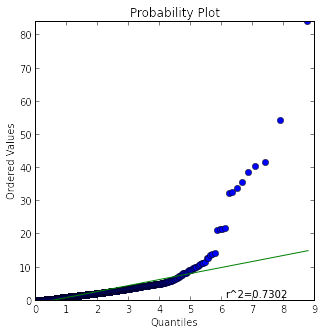

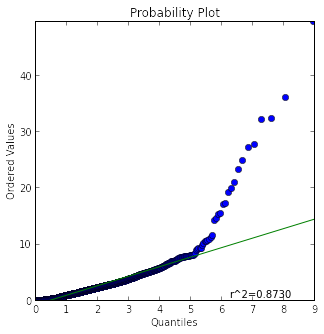

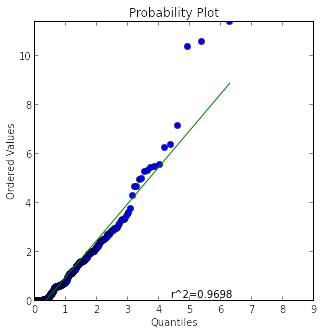

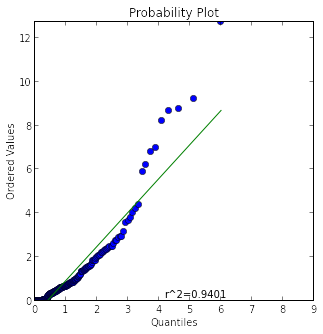

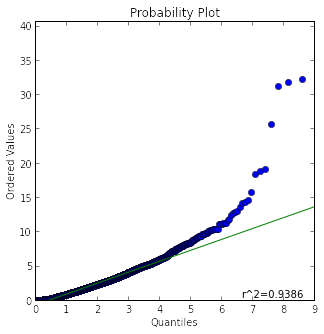

In [10]:
for i in xrange(5):
    r = tau[j_==i]
    intervalr = r[1:] - r[:-1]
    m1 = intervalr

    rcParams['figure.figsize'] = 5, 5
    stats.probplot(m1, dist="expon", plot=plt)
    plt.axis([0,9,min(m1),max(m1)])
    plt.show()
